In [23]:
# !pip install SimpleITK
# !pip install matplotlib
# !pip install scikit-learn
# !pip install segmentation_models

In [9]:
import SimpleITK as sitk
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [10]:
# adc_folder_path = '/content/drive/My Drive/MSc Project/BONBID2023_Train/1ADC_ss'
adc_folder_path = 'BONBID2023_Train/1ADC_ss'
adc_files = [os.path.join(adc_folder_path, f) for f in os.listdir(adc_folder_path) if f.endswith('.mha')]
adc_files = sorted(adc_files)

In [11]:
# zadc_folder_path = '/content/drive/My Drive/MSc Project/BONBID2023_Train/2Z_ADC'
zadc_folder_path = 'BONBID2023_Train/2Z_ADC'
zadc_files = [os.path.join(zadc_folder_path, f) for f in os.listdir(zadc_folder_path) if f.endswith('.mha')]
zadc_files = sorted(zadc_files)

In [12]:
# label_folder_path = '/content/drive/My Drive/MSc Project/BONBID2023_Train/3LABEL'
label_folder_path = 'BONBID2023_Train/3LABEL'
label_files = [os.path.join(label_folder_path, f) for f in os.listdir(label_folder_path) if f.endswith('.mha')]
label_files = sorted(label_files)

# **Read and display data**

Read and display ADC data

In [13]:
adc_data = []
adc_stik_data = []
for file in adc_files:
    image = sitk.ReadImage(file)
    adc_stik_data.append(image)
    array = sitk.GetArrayFromImage(image)
    adc_data.append(array)

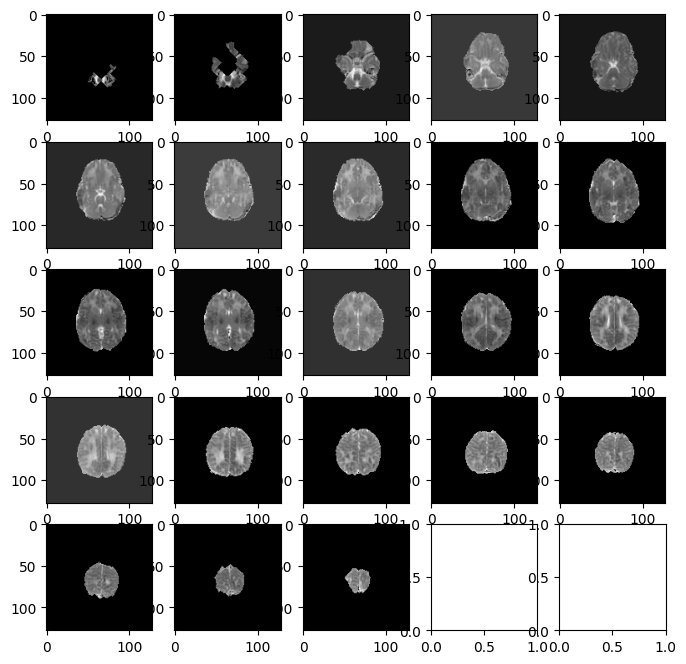

In [14]:
fig, axes = plt.subplots(5,5, figsize=(8,8))

for i,ax in enumerate(axes.flat):
    if i < adc_data[0].shape[0]:
        ax.imshow(adc_data[0][i], cmap='gray')

Read and display Zadc data

In [15]:
zadc_data = []
for file in zadc_files:
    image = sitk.ReadImage(file)
    array = sitk.GetArrayFromImage(image)
    zadc_data.append(array)

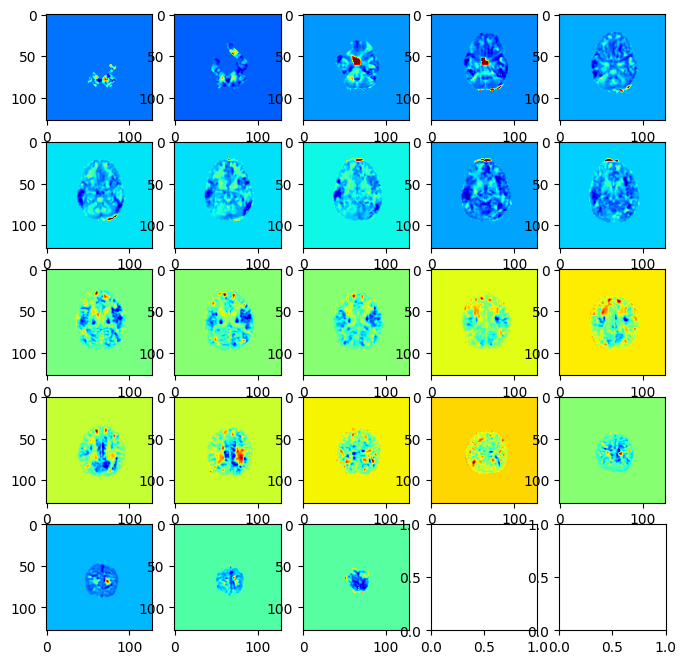

In [16]:
fig, axes = plt.subplots(5,5, figsize=(8,8))

for i,ax in enumerate(axes.flat):
    if i < zadc_data[0].shape[0]:
        ax.imshow(zadc_data[0][i], cmap="jet")

Read and display label data

In [17]:
label_data = []
for file in label_files:
    image = sitk.ReadImage(file)
    array = sitk.GetArrayFromImage(image)
    label_data.append(array)

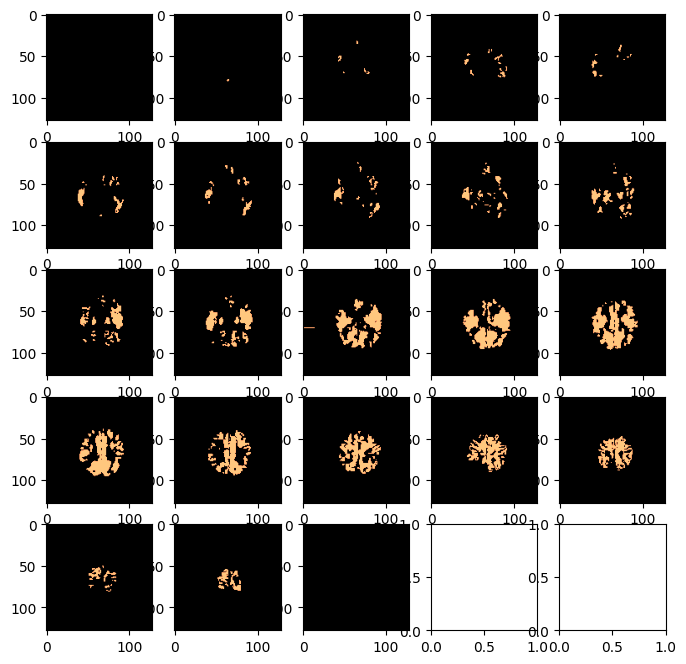

In [18]:
fig, axes = plt.subplots(5,5, figsize=(8,8))

for i,ax in enumerate(axes.flat):
    if i < label_data[0].shape[0]:
        ax.imshow(label_data[0][i], cmap="copper")

# **Ready data for training**

In [19]:
# Flatten a list of data with n length and (m, 128, 128) shape of each array, so it becomes a list of n*m of arrays of shape (128, 128)

flattened_adc_data = [item for sublist in adc_data for item in sublist]
flattened_zadc_data = [item for sublist in zadc_data for item in sublist]
flattened_label_data = [item for sublist in label_data for item in sublist]


In [21]:
from sklearn.model_selection import train_test_split
flattened_zadc_data_train, flattened_zadc_data_test, flattened_label_data_train, flattened_label_data_test = train_test_split(flattened_zadc_data, flattened_label_data, test_size=0.1, random_state=42)

In [22]:
def slice_image(image):
    """
    Slices the given image into 64x64 patches.
    
    Args:
    image (numpy.ndarray): The image to be sliced, expected shape is (H, W).
    
    Returns:
    list: A list of 64x64 image patches.
    """
    patches = []
    h, w = image.shape
    
    if (h, w) == (256, 256):
        # Slicing 256x256 image into sixteen non-overlapping 64x64 patches
        for i in range(0, h, 64):
            for j in range(0, w, 64):
                patches.append(image[i:i+64, j:j+64])
    elif (h, w) == (160, 160):
        # Slicing 160x160 image with overlap to create 64x64 patches
        for i in range(0, h-64+1, 64):
            for j in range(0, w-64+1, 64):
                patches.append(image[i:i+64, j:j+64])
        # Adding overlapping patches
        patches.append(image[96:160, 96:160])
    elif (h, w) == (128, 128):
        # Slicing 128x128 image with overlap to create 64x64 patches
        for i in range(0, h-64+1, 64):
            for j in range(0, w-64+1, 64):
                patches.append(image[i:i+64, j:j+64])
    elif (h, w) == (64, 64):
        # Returning the image itself if it's already 64x64
        patches.append(image)
    else:
        raise ValueError("Unsupported image size. Expected (64, 64), (128, 128), (160, 160), or (256, 256).")
    
    return patches

def process_images_and_labels(images, labels):
    """
    Processes lists of images and labels, slicing each into 64x64 patches.
    
    Args:
    images (list): List of numpy.ndarray images.
    labels (list): List of numpy.ndarray labels corresponding to the images.
    
    Returns:
    tuple: Two lists containing the sliced images and corresponding labels.
    """
    all_image_patches = []
    all_label_patches = []
    
    for image, label in zip(images, labels):
        image_patches = slice_image(image)
        label_patches = slice_image(label)
        
        all_image_patches.extend(image_patches)
        all_label_patches.extend(label_patches)
    
    return all_image_patches, all_label_patches


In [23]:
flattened_cropped_zadc_data_list, flattened_cropped_label_data_list = process_images_and_labels(flattened_zadc_data_train, flattened_label_data_train)

flattened_test_cropped_zadc_data_list, flattened_test_cropped_label_data_list = process_images_and_labels(flattened_zadc_data_test, flattened_label_data_test)

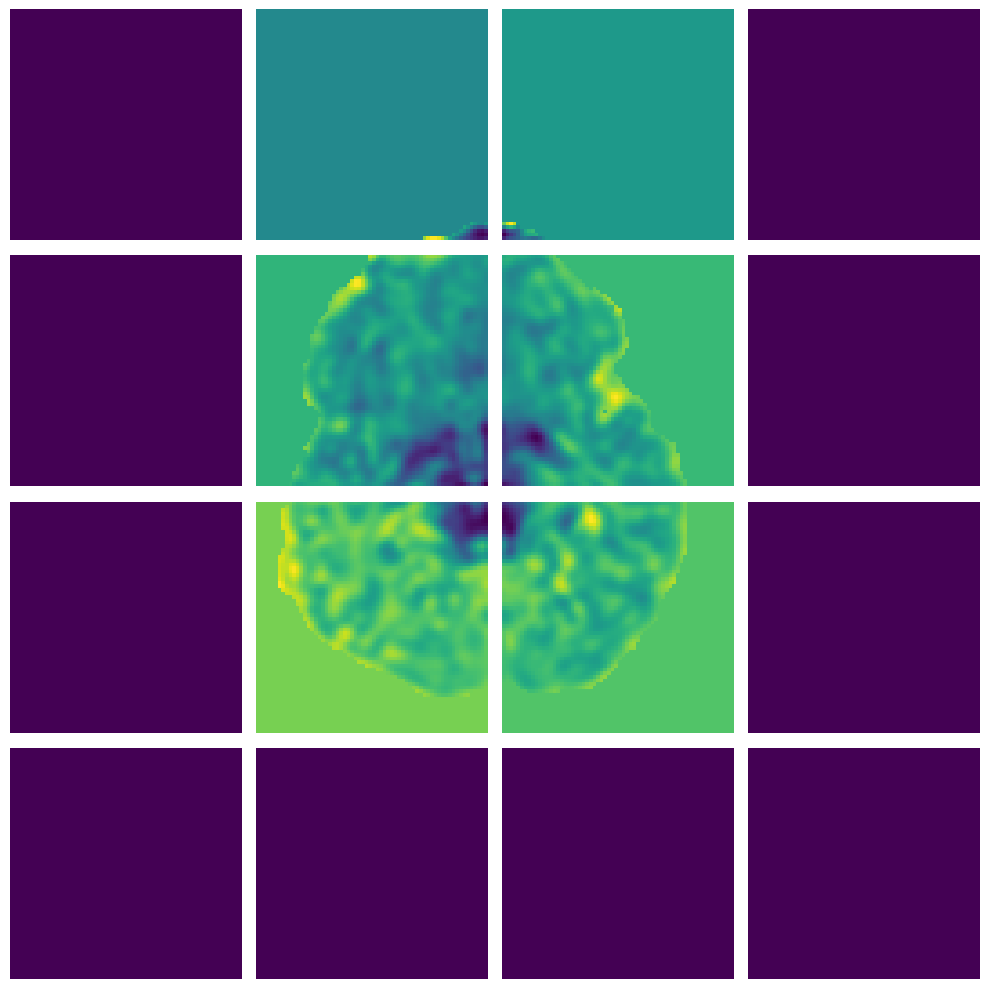

In [24]:
def display_patches(original_image, patches):
    """
    Display the 64x64 patches in a grid to verify their placement.
    
    Args:
    original_image (numpy.ndarray): The original image before slicing.
    patches (list): A list of 64x64 image patches.
    """
    h, w = original_image.shape
    fig, axs = plt.subplots(h // 64, w // 64, figsize=(10, 10))
    
    patch_index = 0
    for i in range(h // 64):
        for j in range(w // 64):
            axs[i, j].imshow(patches[patch_index])
            axs[i, j].axis('off')
            patch_index += 1

    plt.tight_layout()
    plt.show()

# Display patches for the first image
original_image = flattened_zadc_data_train[3]
patches = slice_image(original_image)
display_patches(original_image, patches)

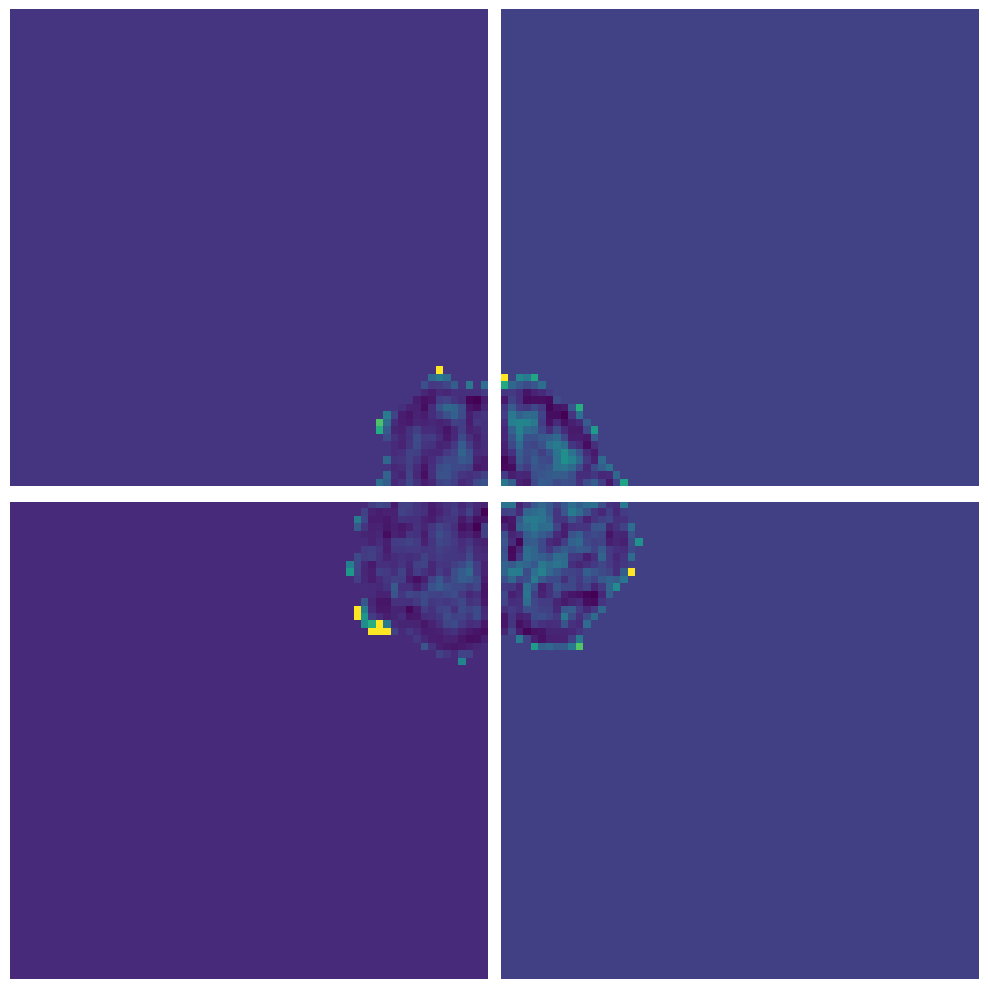

In [25]:
# Display patches for the first image
original_image = flattened_zadc_data_test[3]
patches = slice_image(original_image)
display_patches(original_image, patches)

In [26]:
# Train data
# Convert the list of arrays to a single NumPy array
flattened_cropped_zadc_data = np.array(flattened_cropped_zadc_data_list)

# Reshape the array to have shape (num_samples, 128, 128, 1)
flattened_cropped_zadc_data = flattened_cropped_zadc_data.reshape((len(flattened_cropped_zadc_data_list), 64, 64, 1))

# Print the shape to verify
print(flattened_cropped_zadc_data.shape)

# If you also have label data in the same format

flattened_cropped_label_data = np.array(flattened_cropped_label_data_list)
flattened_cropped_label_data = flattened_cropped_label_data.reshape((len(flattened_cropped_label_data_list), 64, 64, 1))

# Print the shape to verify
print(flattened_cropped_label_data.shape)

(22944, 64, 64, 1)
(22944, 64, 64, 1)


In [27]:
#Test Data
# Convert the list of arrays to a single NumPy array
flattened_test_cropped_zadc_data = np.array(flattened_test_cropped_zadc_data_list)

# Reshape the array to have shape (num_samples, 128, 128, 1)
flattened_test_cropped_zadc_data = flattened_test_cropped_zadc_data.reshape((len(flattened_test_cropped_zadc_data_list), 64, 64, 1))

# Print the shape to verify
print(flattened_test_cropped_zadc_data.shape)

# If you also have label data in the same format

flattened_test_cropped_label_data = np.array(flattened_test_cropped_label_data_list)
flattened_test_cropped_label_data = flattened_test_cropped_label_data.reshape((len(flattened_test_cropped_label_data_list), 64, 64, 1))

# Print the shape to verify
print(flattened_test_cropped_label_data.shape)

(2828, 64, 64, 1)
(2828, 64, 64, 1)


# **U Net**

In [28]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm
# Segmentation Models: using `keras` framework.

2024-07-27 19:38:21.894650: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-27 19:38:22.027241: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 19:38:22.095921: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 19:38:22.116202: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-27 19:38:22.216982: I tensorflow/core/platform/cpu_feature_guar

Segmentation Models: using `tf.keras` framework.


# *Model Save*

In [55]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.models import load_model
import pickle
import matplotlib.pyplot as plt
import os

# Define paths
checkpoint_dir = '/ResNet18L'
checkpoint_filepath = os.path.join(checkpoint_dir, 'model_checkpoint_{epoch:02d}.keras')
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
latest_checkpoint = max([os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.startswith('model_checkpoint')], key=os.path.getctime, default=None)
log_filepath = 'training_log_ResNetCombinedLoss.csv'

# Create the CSVLogger
csv_logger = CSVLogger(log_filepath, append=True)

# ModelCheckpoint callback to save the model
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_mean_io_u',
    mode='max',
    save_best_only=False,
    save_freq='epoch'
)

# **Resnet18**

In [44]:

import segmentation_models as sm
from sklearn.model_selection import train_test_split

BACKBONE = 'resnet18'

# load your data
x_train, x_val, y_train, y_val = train_test_split(flattened_cropped_zadc_data, flattened_cropped_label_data, test_size=0.2, random_state=42)

# define model
model = sm.Unet(BACKBONE, encoder_weights=None, input_shape=(64, 64, 1))

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(), sm.metrics.FScore()]

model.compile(
    'Adam',
    loss=total_loss,
    metrics=metrics,
)


# Load model from the last checkpoint if it exists
# if latest_checkpoint is not None:
#     model = load_model(latest_checkpoint)
#     print(f"Loaded model from {latest_checkpoint}")

# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
history = model.fit(
   x=x_train,
   y=y_train,
   batch_size=32,
   epochs=700,
   validation_data=(x_val, y_val),
   callbacks=[model_checkpoint_callback, csv_logger]
)

Epoch 1/700


I0000 00:00:1722078451.894326    2105 service.cc:146] XLA service 0x7fdccc06e580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722078451.895603    2105 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2024-07-27 12:07:32.305353: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-27 12:07:33.651518: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1722078470.898297    2105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


574/574 ━━━━━━━━━━━━━━━━━━━━ 82s 97ms/step - f1-score: 0.3789 - iou_score: 0.2839 - loss: 0.6617 - val_f1-score: 0.6444 - val_iou_score: 0.5275 - val_loss: 0.3628
Epoch 2/700
574/574 ━━━━━━━━━━━━━━━━━━━━ 33s 58ms/step - f1-score: 0.6653 - iou_score: 0.5401 - loss: 0.3455 - val_f1-score: 0.7050 - val_iou_score: 0.5870 - val_loss: 0.3023
Epoch 3/700
574/574 ━━━━━━━━━━━━━━━━━━━━ 34s 59ms/step - f1-score: 0.6742 - iou_score: 0.5495 - loss: 0.3375 - val_f1-score: 0.6334 - val_iou_score: 0.5092 - val_loss: 0.3758
Epoch 4/700
574/574 ━━━━━━━━━━━━━━━━━━━━ 34s 59ms/step - f1-score: 0.7169 - iou_score: 0.5921 - loss: 0.2934 - val_f1-score: 0.6933 - val_iou_score: 0.5696 - val_loss: 0.3172
Epoch 5/700
574/574 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - f1-score: 0.6747 - iou_score: 0.5430 - loss: 0.3376 - val_f1-score: 0.6389 - val_iou_score: 0.5200 - val_loss: 0.3702
Epoch 6/700
574/574 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - f1-score: 0.7006 - iou_score: 0.5753 - loss: 0.3106 - val_f1-score: 0.7072 - val

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the training log
log_filepath = 'training_log_ResNetCombinedLoss.csv'
training_log = pd.read_csv(log_filepath)

# Check the number of epochs logged
print(f"Number of epochs logged: {len(training_log)}")

# Display the first few rows to check the content
print(training_log.head())


Number of epochs logged: 752
   epoch  f1-score  iou_score      loss  val_f1-score  val_iou_score  val_loss
0      0  0.558498   0.437263  0.456253      0.651803       0.519571  0.362335
1      1  0.678445   0.549046  0.332557      0.621523       0.506617  0.385930
2      2  0.673248   0.545796  0.337358      0.655952       0.540897  0.350326
3      3  0.704318   0.579466  0.306198      0.722501       0.606392  0.284920
4      4  0.695579   0.572356  0.314640      0.715132       0.599644  0.295222


In [57]:
# Initialize a dictionary to store the history data
history_dict = {
    'f1-score': training_log['f1-score'].tolist(),
    'val_f1-score': training_log['val_f1-score'].tolist(),
    'iou_score': training_log['iou_score'].tolist(),
    'val_iou_score': training_log['val_iou_score'].tolist(),
    'loss': training_log['loss'].tolist(),
    'val_loss': training_log['val_loss'].tolist()
}

# Mimic the Keras history object
class History:
    def __init__(self, history_dict):
        self.history = history_dict

history = History(history_dict)


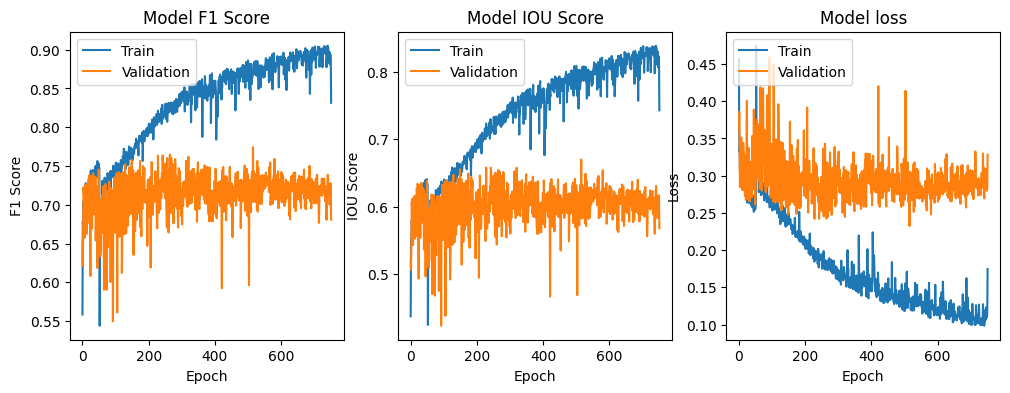

In [58]:
# Plot training & validation accuracy and loss values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 2)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model IOU Score')
plt.ylabel('IOU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 3)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [59]:
import segmentation_models as sm
from tensorflow.keras.losses import Loss
from tensorflow.keras.metrics import Metric

# dice_loss = sm.losses.DiceLoss()
# focal_loss = sm.losses.BinaryFocalLoss()
# total_loss = sm.losses.DiceLoss() + (1 * sm.losses.BinaryFocalLoss())

# Custom objects for model loading
custom_objects = {
    'DiceLoss': sm.losses.DiceLoss(),
    'BinaryFocalLoss': sm.losses.BinaryFocalLoss(),
    'SumOfLosses': sm.losses.DiceLoss() + (1 * sm.losses.BinaryFocalLoss()),
    'IOUScore': sm.metrics.IOUScore(),
    'FScore': sm.metrics.FScore()
}


In [60]:
from tensorflow.keras.models import load_model

if latest_checkpoint is not None:
    try:
        model = load_model(latest_checkpoint, custom_objects=custom_objects)
        print(f"Loaded model from {latest_checkpoint}")
    except Exception as e:
        print(f"Error loading model: {e}")


Error loading model: Unable to reconstruct an instance of 'SumOfLosses' because the class is missing a `from_config()` method. Full object config: {'module': 'segmentation_models.base.objects', 'class_name': 'SumOfLosses', 'config': 'dice_loss_plus_1binary_focal_loss', 'registered_name': 'SumOfLosses'}


In [62]:
latest_checkpoint

'/ResNet18L/model_checkpoint_700.keras'

In [66]:
model = load_model('/ResNet18L/model_checkpoint_700.keras', safe_mode=False, compile=False)

In [67]:
def stitch_image(patches, original_shape):
    """
    Stitches 64x64 patches back together into the original image.
    
    Args:
    patches (list): A list of 64x64 image patches.
    original_shape (tuple): The shape of the original image (height, width).
    
    Returns:
    numpy.ndarray: The reconstructed image.
    """
    h, w = original_shape
    reconstructed_image = np.zeros(original_shape)
    
    patch_index = 0
    for i in range(0, h, 64):
        for j in range(0, w, 64):
            reconstructed_image[i:i+64, j:j+64] = patches[patch_index]
            patch_index += 1
    
    return reconstructed_image

I0000 00:00:1722113027.097672  231338 service.cc:146] XLA service 0x7f543c003df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722113027.098867  231338 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2024-07-27 21:43:47.298225: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-27 21:43:48.055771: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


I0000 00:00:1722113035.661257  231338 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


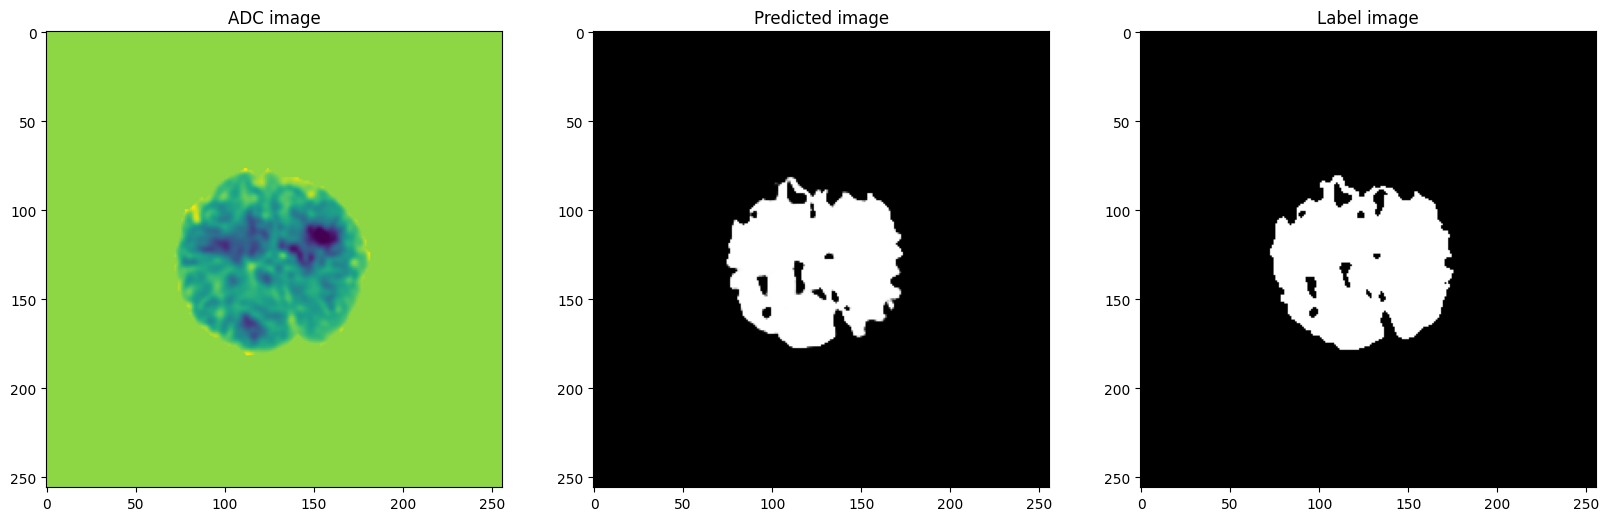

In [68]:
IMAGE_NUMBER = 300
original_image = flattened_zadc_data_test[IMAGE_NUMBER]
label_image = flattened_label_data_test[IMAGE_NUMBER]
patches = slice_image(original_image)

patches_data = np.array(patches)

# Reshape the array to have shape (num_samples, 128, 128, 1)
patches_data = patches_data.reshape((len(patches), 64, 64, 1))

predictions = model.predict(patches_data)
predictions = predictions.reshape((len(predictions), 64, 64))
reconstructed_image = stitch_image(predictions, original_image.shape)


plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title('ADC image')

plt.subplot(1, 3, 2)
plt.imshow(reconstructed_image, cmap="grey")
plt.title('Predicted image')

plt.subplot(1, 3, 3)
plt.imshow(label_image, cmap="grey")
plt.title('Label image')

plt.show()

In [74]:
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(), sm.metrics.FScore()]

In [81]:
model.compile(
    'Adam',
    loss=focal_loss,
    metrics=metrics,
)

# Evaluate the model
evaluation = model.evaluate(flattened_test_cropped_zadc_data, flattened_test_cropped_label_data, batch_size=32)

# Print the results
print("Evaluation results on test data:")
print(f"Focal Loss: {evaluation[0]}")
print(f"IOU Score: {evaluation[1]}")
print(f"F1 Score: {evaluation[2]}")

89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - f1-score: 0.5549 - iou_score: 0.4614 - loss: 0.0144
Evaluation results on test data:
Focal Loss: 0.011958681978285313
IOU Score: 0.4764184355735779
F1 Score: 0.5712214708328247


In [82]:
model.compile(
    'Adam',
    loss=dice_loss,
    metrics=metrics,
)

# Evaluate the model
evaluation = model.evaluate(flattened_test_cropped_zadc_data, flattened_test_cropped_label_data, batch_size=32)

# Print the results
print("Evaluation results on test data:")
print(f"Dice Loss: {evaluation[0]}")
print(f"IOU Score: {evaluation[1]}")
print(f"F1 Score: {evaluation[2]}")

89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - f1-score: 0.5549 - iou_score: 0.4614 - loss: 0.4450
Evaluation results on test data:
Dice Loss: 0.4249489903450012
IOU Score: 0.4764184355735779
F1 Score: 0.5712214708328247


In [83]:
model.compile(
    'Adam',
    loss=total_loss,
    metrics=metrics,
)

# Evaluate the model
evaluation = model.evaluate(flattened_test_cropped_zadc_data, flattened_test_cropped_label_data, batch_size=32)

# Print the results
print("Evaluation results on test data:")
print(f"Total Loss: {evaluation[0]}")
print(f"IOU Score: {evaluation[1]}")
print(f"F1 Score: {evaluation[2]}")

89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - f1-score: 0.5549 - iou_score: 0.4614 - loss: 0.4594
Evaluation results on test data:
Total Loss: 0.43690773844718933
IOU Score: 0.4764184355735779
F1 Score: 0.5712214708328247
